We're going to talk about a potentially dangerous topic today: how to enhance your images. You've probably heard negative stories in science news about image enhancement (see [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4210356/) review, for instance). Image enhancement can serve an important role in science, though, as it can aid human interpretation of images (for example, improving contrast or removing noise). Others can be used for pre-processing steps for quantitative methods. Finally, (for less "scientific" purposes) they cam be used to make an image more visually appealing for, say, a journal cover. For this reason, image enhancement is a subjective in nature.

We will be talking about two different methods of image enhancement: spatial domain methods and frequency domain methods.

## Contrast Enhancement

The simplest case of image enhancement in the spatial domain is *contrast stretching* also known as a *mapping transformation*. In this case, the operation can be expressed as:

$$s = T(r) $$

where r and s are the grey level of f(x,y) and g(x,y), respectively where f(x,y) is the image before the transformation and g(x,y) is the image after transformation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_float
from scipy.special import expit

In [2]:
im = img_as_float(data.camera())

In [3]:
from scipy.linalg import solve

In [26]:
A = [[1**3, 1**2, 1],[12*0.5**2, 6*0.5, 2],[4*1**2, 3*1, 2]]
b = [1, 0, 0]

In [27]:
a, b, c = solve(A,b)

In [35]:
b

-1.9999999999999998

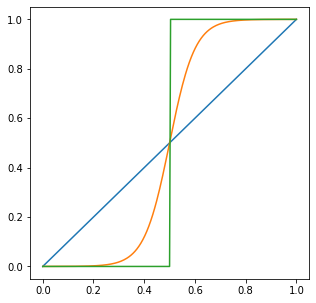

In [61]:
x = np.linspace(0, 1, 257)
y = x
y1 = 1/(1+np.exp(-20*(x-0.5)))
y2 = 0*x
y2[x>0.5] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y)
ax.plot(x, y1)
ax.plot(x, y2)

In [57]:
c

2.9999999999999996

(-0.5, 511.5, 511.5, -0.5)

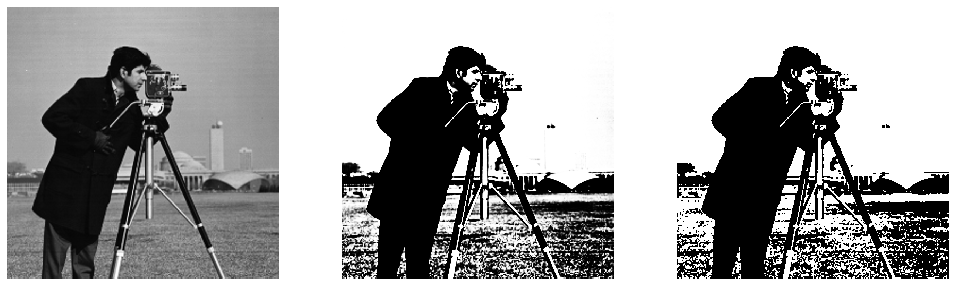

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(im, cmap='gray')
ax[0].axis('off')

im_s = 1/(1+np.exp(-60*(im-0.5)))
ax[1].imshow(im_s, cmap='gray')
ax[1].axis('off')

im_b = im > 0.5
ax[2].imshow(im_b, cmap='gray')
ax[2].axis('off')

Because enhancement at any point in an image depends only on the gray level at that point, techniques in this category are referred to as **point processing**.

Other basic gray-level transformations include:

1. **Image negative**

$$s = L - 1 - r $$

2. **Log transformation**

$$s = c \log{(1+r)} $$

3. **Power-Law Transformation**

$$s = cr^{\gamma} $$

4. **Piecewise-Linear Transformation**

5. **Gray-level slicing**: Display a high-level for all gray levels of interest, and low-level for gray levels outside the range of interest. Makes a binary image. Alternately, preserve the tonalities of the background, and set gray levels of interest to 0 or 1.



(-0.1, 1.1)

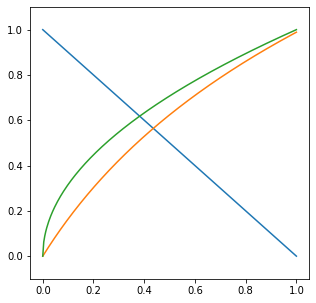

In [88]:
x = np.linspace(0, 1, 257)
y = 1-x
y1 = 0.9*np.log(1+2*x)
y2 = x**0.5


fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y)
ax.plot(x, y1)
ax.plot(x, y2)
ax.set_ylim([-0.1,1.1])

(-0.5, 511.5, 511.5, -0.5)

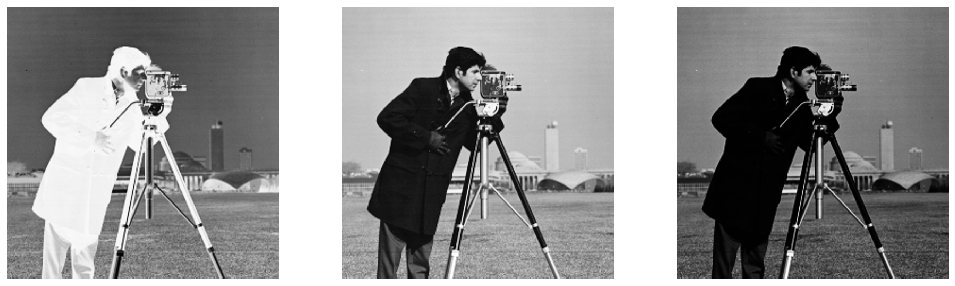

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(1-im, cmap='gray')
ax[0].axis('off')

im_s = 0.9*np.log(1+2*im)
ax[1].imshow(im_s, cmap='gray')
ax[1].axis('off')

im_b = im**1.6
ax[2].imshow(im_b, cmap='gray')
ax[2].axis('off')

1. Construct a piecewise-linear transformation function, and test it out on the cameraman image.

# Histogram Processing

The histogram of an image is used for several types of image enhancements. Let's take a look at the histogram of our cameraman image:

<BarContainer object of 100 artists>

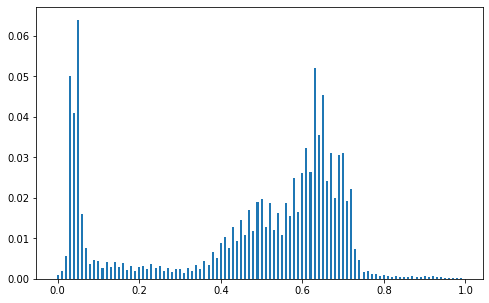

In [16]:
hist, bins = np.histogram(im, bins=np.linspace(0, 1, 101))
fig, ax = plt.subplots(figsize=(8,5))

ax.bar(bins[:-1], hist/512**2, width=0.005)

Consider the function $s = T(r)$ that satisfies the following:

1. T(r) is *single-valued* and *monotonically increasing*
2. $0 \le T(r) \le 1$ for $0 \le r \le 1$

The requirement that T(r) be single-valued is necessary to guarantee that the inverse transformation will exist. If the function isn't monotonically increasing, you will get some inverted gray levels.

We are going to treat the histogram of the image as a probability distribution function. If we normalize the plot to the total number of pixels, this works out, so that the area under the curve is 1. We will define our transform in terms of the probability distribution:

$$s = T(r) = \int_0^r{p_r(w)dw} $$

The discrete form can be expressed:

$$s_k = T(r_k) = \sum_{j=0}^{k}{p_r(r_j)} = \sum_{j=0}^k{\frac{n_j}{n}} $$

This will create a probability distribution that approximates a uniform probability density function. This has the effect of "spreading" the histogram out more, hence the name **histogram equalization**. We will use the `skimage` function `equalize_hist` from the `exposure` module. This has the advantage of of having gray levels that span the entire gray scale. 

In [7]:
from skimage.exposure import equalize_hist
from skimage import exposure
from scipy.stats import cumfreq

<BarContainer object of 100 artists>

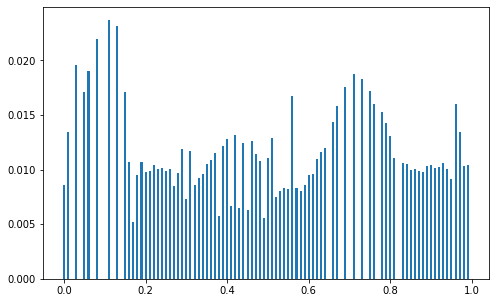

In [15]:
im_e = equalize_hist(im, nbins=256)

hist, bins = np.histogram(im_e, bins=np.linspace(0, 1, 101))
fig, ax = plt.subplots(figsize=(8,5))

ax.bar(bins[:-1], hist/512**2, width=0.005)


(-0.5, 511.5, 511.5, -0.5)

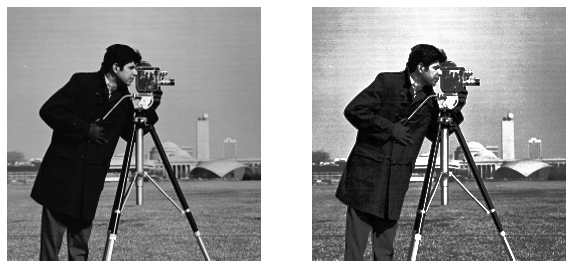

In [124]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].imshow(im, cmap='gray')
ax[0].axis('off')

ax[1].imshow(im_e, cmap='gray')
ax[1].axis('off')

With histogram equalization, the shape of the output histogram was automatically determined. But sometimes, this isn't useful. Other times, we may want to force a specific histogram shape on our image. This is called **histogram matching** or **histogram specification**.

To perform this kind of transformation, we are going to have to use two different probability distributions:

$$s = T(r) =  \int_0^r{p_r(w)dw}$$

And we will also define s in terms of the probability distribution that we are seeking to obtain:

$$s = G(z) = \int_0^r{p_z(t)dt} $$

Obtaining an image with the desired density function can then be found using the following steps:

1. Obtain the transformation function T(r) using the method shown above.
2. Obtain the function G(z) from the histogram of interest
3. Obtain the inverse transform $G^{-1}$
4. Obtain the output image by using the function

$$z = G^{-1}(s) = G^{-1}[T(r)] $$

Let's try it using two different images:

Text(0.5, 1.0, 'Matched')

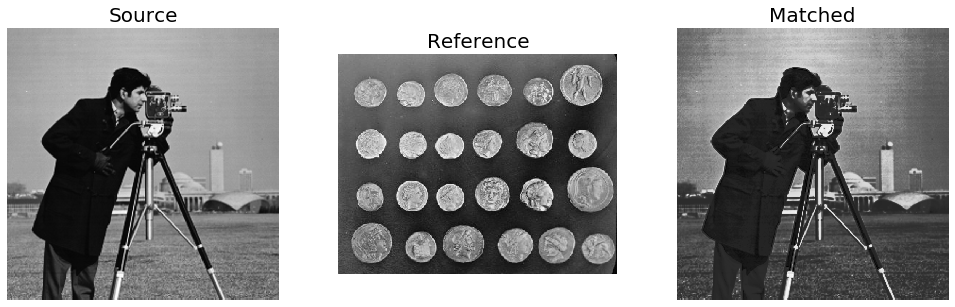

In [8]:
im2 = img_as_float(data.coins())

fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Source', fontsize=20)

ax[1].imshow(im2, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Reference', fontsize=20)

im_m = exposure.match_histograms(im, im2)
ax[2].imshow(im_m, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Matched', fontsize=20)

Text(0, 0.5, 'Pixel Value')

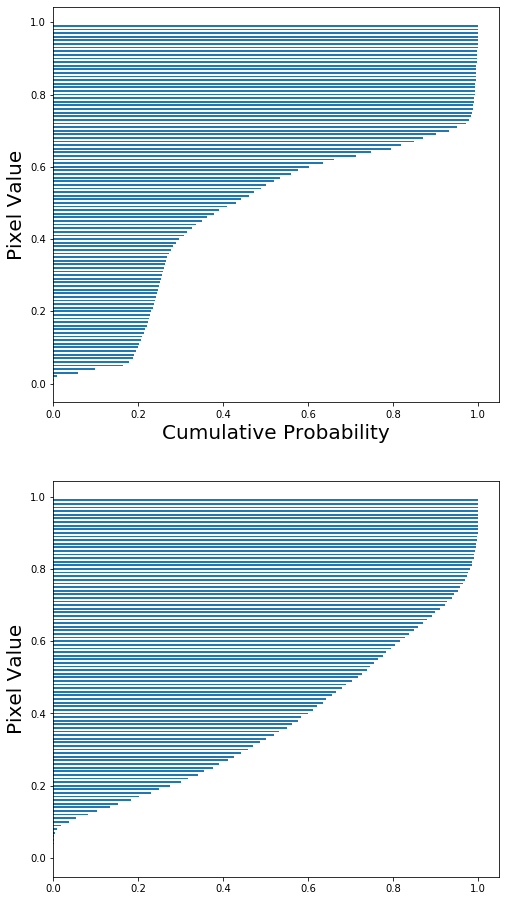

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 16))

hist, bins = np.histogram(im, bins=np.linspace(0, 1, 101))
ax[0].barh(bins[:-1], np.cumsum(hist)/(512*512), 0.005)
ax[0].set_xlabel('Cumulative Probability', fontsize=20)
ax[0].set_ylabel('Pixel Value', fontsize=20)

hist, bins = np.histogram(im2, bins=np.linspace(0, 1, 101))
ax[1].barh(bins[:-1], np.cumsum(hist)/(303*384), 0.005)
ax[1].set_ylabel('Pixel Value', fontsize=20)

You can do the same thing with colored images:

Text(0.5, 1.0, 'Matched')

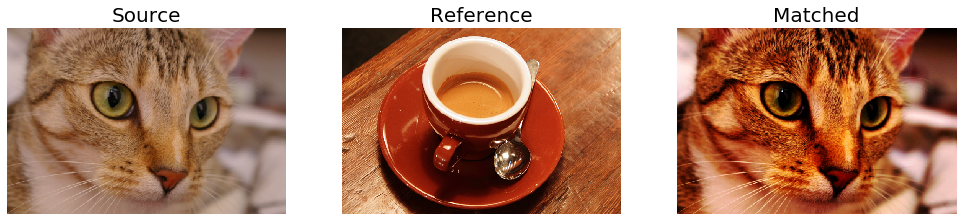

In [68]:
im = img_as_float(data.chelsea())
im2 = img_as_float(data.coffee())

fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Source', fontsize=20)

ax[1].imshow(im2, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Reference', fontsize=20)

im_m = exposure.match_histograms(im, im2)
ax[2].imshow(im_m, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Matched', fontsize=20)

# Local enhancement

The methods discussed so far are *global* enhancement techniques, meaning pixels are modified by a transformation function that applies to the whole image. Sometimes though, you would like to restrict enhancement to a region within the image. This is known as *local enhancement*. You can imagine enancing the contrast of a single region in an image. Or modify the entire image, piece by piece, with a separate transformation defined for each location. For instance, you could perform a histogram equalization on subsets of the image, instead of the entire image all at once.

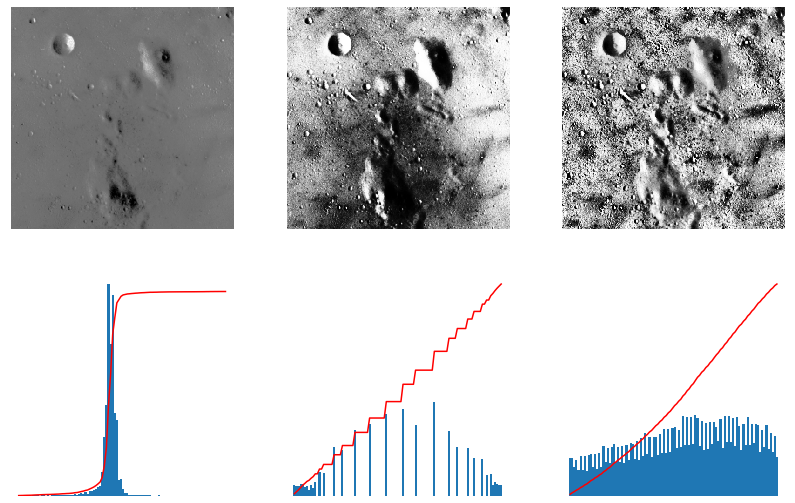

In [58]:
from skimage.filters import rank
from skimage.morphology import square

im = img_as_float(data.moon())
im_e = equalize_hist(im)
im_le = img_as_float(rank.equalize(im, selem=square(80)))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,9))

ax[0,0].imshow(im, cmap='gray')
ax[0,1].imshow(im_e, cmap='gray')
ax[0,2].imshow(im_le, cmap='gray')

hist, bins = np.histogram(im, bins=np.linspace(0, 1, 101))
ax[1,0].bar(bins[:-1], 5*hist/(512**2), width=0.01)
ax[1,0].plot(bins[:-1], np.cumsum(hist)/(512*512), color='r')

hist, bins = np.histogram(im_e, bins=np.linspace(0, 1, 101))
ax[1,1].bar(bins[:-1], 5*hist/(512**2), width=0.01)
ax[1,1].plot(bins[:-1], np.cumsum(hist)/(512*512), color='r')

hist, bins = np.histogram(im_le, bins=np.linspace(0, 1, 101))
ax[1,2].bar(bins[:-1], 25*hist/(512**2), width=0.01)
ax[1,2].plot(bins[:-1], np.cumsum(hist)/(512*512), color='r')

for axj in ax:
    for axi in axj:
        axi.axis('off')

Local enhancement can be much more powerful, where the *local* statistics of the histogram are used as the basis for making changes to an individual pixel. Local enhancement is ideal when part of the image is acceptable, but other parts may contain hidden features of interest.

# Arithmetic and Logical Operations

1. Image subtraction
    * Can be used to remove background from image. An interesting application is *mask mode radiography* where a background Xray image is subtracted from images after injecting a contrast agent.
2. Image averaging
    * Suppose you have a series of images of the same object, but all have random noise. You can average all the images to get an "average" image that removes the noise.
    
    

In [90]:
im = img_as_float(data.camera())
noise = 0.1*(np.random.random_sample(size=(512,512)) - 0.5)

In [106]:
ima = np.zeros((512,512,30))
for i in range(0, 30):
    noise = 0.9*(np.random.random_sample(size=(512,512)) - 0.5)
    ima[:, :, i] = im + noise

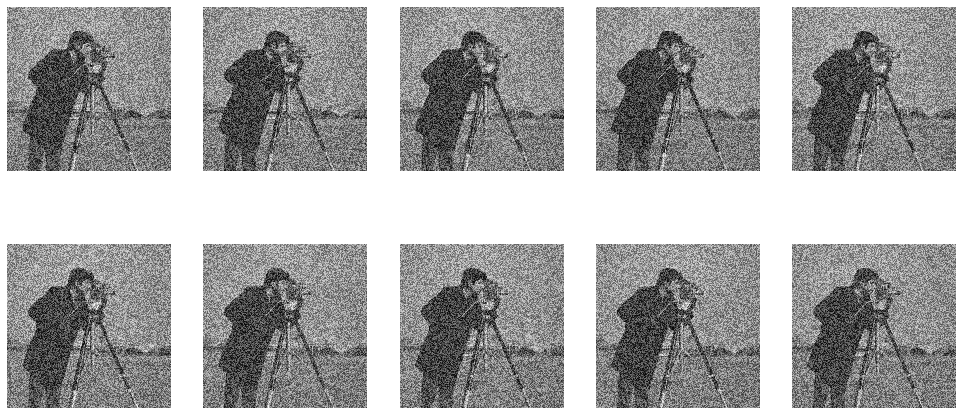

In [107]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(17,8))

axes = [item for sublist in axes for item in sublist]

for i, ax in enumerate(axes):
    ax.imshow(ima[:, :, i], cmap='gray')
    ax.axis('off')

In [108]:
im_avg = np.average(ima, axis=2)

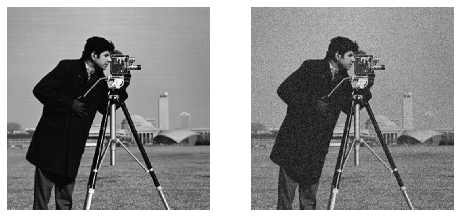

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_avg, cmap='gray')